# <center> Automatic Ticket Classification </center>

#### Developed by:
##### 1. Chandrasekaran Baskaran
##### 2. Sankar Thulasimani

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
from nltk.corpus import stopwords
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from nltk.tokenize import RegexpTokenizer

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('complaints.json', 'r') # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
#info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [5]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [6]:
#Assign new column names
def replace_name(col_name):
    if '_source.' in col_name:
        return col_name[8:]
    elif '_' in col_name:
        return col_name[1:] 
    else:
        return col_name

In [7]:
cols = list(df.columns )
for col in cols:
    print(col + '===========>>>' + replace_name(col))

_index===========>>>index
_type===========>>>type
_id===========>>>id
_score===========>>>score
_source.tags===========>>>tags
_source.zip_code===========>>>zip_code
_source.complaint_id===========>>>complaint_id
_source.issue===========>>>issue
_source.date_received===========>>>date_received
_source.state===========>>>state
_source.consumer_disputed===========>>>consumer_disputed
_source.product===========>>>product
_source.company_response===========>>>company_response
_source.company===========>>>company
_source.submitted_via===========>>>submitted_via
_source.date_sent_to_company===========>>>date_sent_to_company
_source.company_public_response===========>>>company_public_response
_source.sub_product===========>>>sub_product
_source.timely===========>>>timely
_source.complaint_what_happened===========>>>complaint_what_happened
_source.sub_issue===========>>>sub_issue
_source.consumer_consent_provided===========>>>consumer_consent_provided


In [8]:
#Changing the column names of the dataframe
for col in cols:
    df.rename(columns={col:replace_name(col)},inplace=True)

#Print the new column names
print(df.columns)
df.head(5)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [9]:
#Check the percentage of null data for each column
round(100*df.isnull().sum()/len(df),2).sort_values(ascending=False)

company_public_response      99.99
tags                         86.08
sub_issue                    59.12
sub_product                  13.50
zip_code                      8.63
state                         2.54
consumer_consent_provided     1.29
company                       0.00
complaint_what_happened       0.00
timely                        0.00
date_sent_to_company          0.00
submitted_via                 0.00
index                         0.00
company_response              0.00
type                          0.00
consumer_disputed             0.00
date_received                 0.00
issue                         0.00
complaint_id                  0.00
score                         0.00
id                            0.00
product                       0.00
dtype: float64

In [10]:
#Check the rows with more than 80% data as null
len(df[round(100*df.isnull().sum(axis=1)/len(df.columns),2) >= 80.00])

0

In [11]:
#Assign nan in place of blanks in the complaints column
print(len(df[df.complaint_what_happened.str.strip() == '']))
df.complaint_what_happened.replace('',np.NaN,inplace=True)

57241


In [12]:
#Looking at null value percentage
round(100*df.isnull().sum()/len(df),2).sort_values(ascending=False)

company_public_response      99.99
tags                         86.08
complaint_what_happened      73.09
sub_issue                    59.12
sub_product                  13.50
zip_code                      8.63
state                         2.54
consumer_consent_provided     1.29
company                       0.00
timely                        0.00
date_sent_to_company          0.00
submitted_via                 0.00
index                         0.00
company_response              0.00
type                          0.00
consumer_disputed             0.00
date_received                 0.00
issue                         0.00
complaint_id                  0.00
score                         0.00
id                            0.00
product                       0.00
dtype: float64

In [13]:
#Remove all rows where complaints column is nan
df = df[~(df.complaint_what_happened.isna())]
len(df)

21072

In [14]:
#Check the percentage of null data
round(100*df.isnull().sum()/len(df),2).sort_values(ascending=False)

company_public_response      99.99
tags                         81.89
sub_issue                    38.80
zip_code                     22.04
sub_product                  10.01
state                         0.68
index                         0.00
company                       0.00
complaint_what_happened       0.00
timely                        0.00
date_sent_to_company          0.00
submitted_via                 0.00
product                       0.00
company_response              0.00
type                          0.00
consumer_disputed             0.00
date_received                 0.00
issue                         0.00
complaint_id                  0.00
score                         0.00
id                            0.00
consumer_consent_provided     0.00
dtype: float64

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [15]:
# # Write your function here to clean the text and remove all the unnecessary elements.
#from tqdm.notebook import tqdm
#tqdm.pandas()

df['complaint_clean'] = df['complaint_what_happened'].str.lower()
df['complaint_clean'] = df['complaint_clean'].replace(regex=[r'\{(.*?)\}',r'\((.*?)\)',r'\w*\d\w*'], value="")

punctuation = list(set(string.punctuation))


def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens

def process(text):
    text = whitespace_tokenizer(text)
    text = [w for w in text if w not in punctuation]
    return text

df['complaint_clean'] = df['complaint_clean'].apply(process)

In [16]:
#Write your function to Lemmatize the texts
nlp = spacy.load('en_core_web_sm')

def lemmatize(texts):
    doc = nlp(" ".join(texts))
    return ' '.join([token.lemma_ for token in doc])

df['complaint_clean'] = df['complaint_clean'].apply(lemmatize)

In [17]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[["complaint_clean","complaint_what_happened"]]

In [18]:
df_clean = df_clean.reset_index(drop=True)
df_clean

,complaint_clean,complaint_what_happened
0,good morning my name be xxxx xxxx and apprecia...,Good morning my name is XXXX XXXX and I apprec...
1,upgrade my xxxx xxxx card in xx xx and be tell...,I upgraded my XXXX XXXX card in XX/XX/2018 and...
2,chase card be report on xx xx however fraudule...,Chase Card was reported on XX/XX/2019. However...
3,on xx xx while try to book xxxx xxxx ticket co...,"On XX/XX/2018, while trying to book a XXXX XX..."
4,my grand son give I check for deposit it into ...,my grand son give me check for {$1600.00} i de...
...,...,...
21067,after be chase card customer for well over dec...,After being a Chase Card customer for well ove...
21068,on wednesday xx xx xxxx call cha my xxxx xxxx ...,"On Wednesday, XX/XX/XXXX I called Chas, my XXX..."
21069,be not familiar with xxxx pay and do not under...,I am not familiar with XXXX pay and did not un...
21070,have have flawless credit for yr ve have chase...,I have had flawless credit for 30 yrs. I've ha...


In [19]:
#Write your function to extract the POS tags 

def pos_tag(text):
    doc = nlp(text)
    nouns = []
    for token in doc:
        if token.pos_ == 'NOUN':
            nouns.append(token.text)
    return ' '.join(nouns)



df_clean["complaint_POS_removed"] =  df_clean['complaint_clean'].apply(lambda x:pos_tag(x)) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [20]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_clean,complaint_what_happened,complaint_POS_removed
0,good morning my name be xxxx xxxx and apprecia...,Good morning my name is XXXX XXXX and I apprec...,morning name xxxx stop cardmember service writ...
1,upgrade my xxxx xxxx card in xx xx and be tell...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,xxxx card agent upgrade anniversary date agent...
2,chase card be report on xx xx however fraudule...,Chase Card was reported on XX/XX/2019. However...,card report application identity consent servi...
3,on xx xx while try to book xxxx xxxx ticket co...,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx ticket offer ticket reward card informati...
4,my grand son give I check for deposit it into ...,my grand son give me check for {$1600.00} i de...,son deposit chase account fund chase bank acco...
...,...,...,...
21067,after be chase card customer for well over dec...,After being a Chase Card customer for well ove...,chase card customer decade solicitation credit...
21068,on wednesday xx xx xxxx call cha my xxxx xxxx ...,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",credit card provider claim purchase protection...
21069,be not familiar with xxxx pay and do not under...,I am not familiar with XXXX pay and did not un...,xxxx risk consumer chase bank app chase year b...
21070,have have flawless credit for yr ve have chase...,I have had flawless credit for 30 yrs. I've ha...,credit credit card chase freedom xxxx problem ...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




(array([7.071e+03, 6.281e+03, 3.384e+03, 1.751e+03, 9.250e+02, 7.400e+02,
        3.810e+02, 1.470e+02, 8.700e+01, 6.900e+01, 4.600e+01, 3.600e+01,
        2.900e+01, 2.200e+01, 1.700e+01, 1.900e+01, 1.100e+01, 4.000e+00,
        6.000e+00, 6.000e+00, 4.000e+00, 6.000e+00, 2.000e+00, 2.000e+00,
        3.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 4.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([1.800000e+01, 5.861400e+02, 1.154280e+03, 1.722420e+03,
        2.290560e+03, 2.858700e+03, 3.426840e+03, 3.994980e+03,
        4.563120e+03, 5.131260e+03, 5.699400e+03, 6.267540e+03,
        6.835680e+03, 7.403820e+03, 7.971960e+03, 8.540100e+03,
        9.108240e+03, 9.676380e+03, 1.024452e+04, 1.081266e+04,
        1.138080e+04, 1.194894e+04, 1.251708e+04, 1.3085

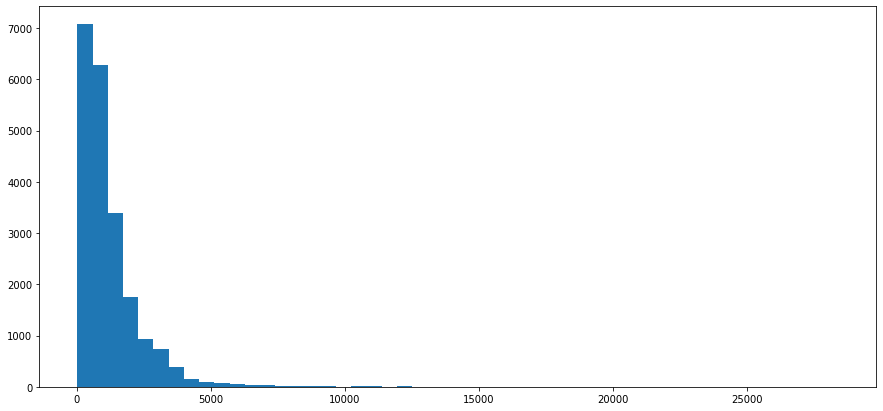

In [21]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(15,7))
lengths = [len(complaint) for complaint in df_clean.complaint_clean]
plt.hist(lengths, bins = 50)

#### Find the top 40 words by frequency among all the articles after processing the text.

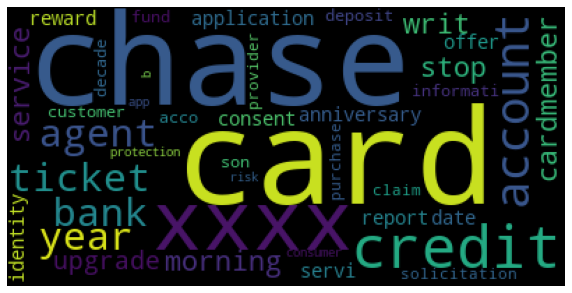

In [22]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
from spacy.lang.en.stop_words import STOP_WORDS
wordcloud = WordCloud(stopwords=STOP_WORDS,max_words=40).generate(str(df_clean.complaint_POS_removed))
print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [23]:
#Removing -PRON- from the text corpus
df_clean['complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

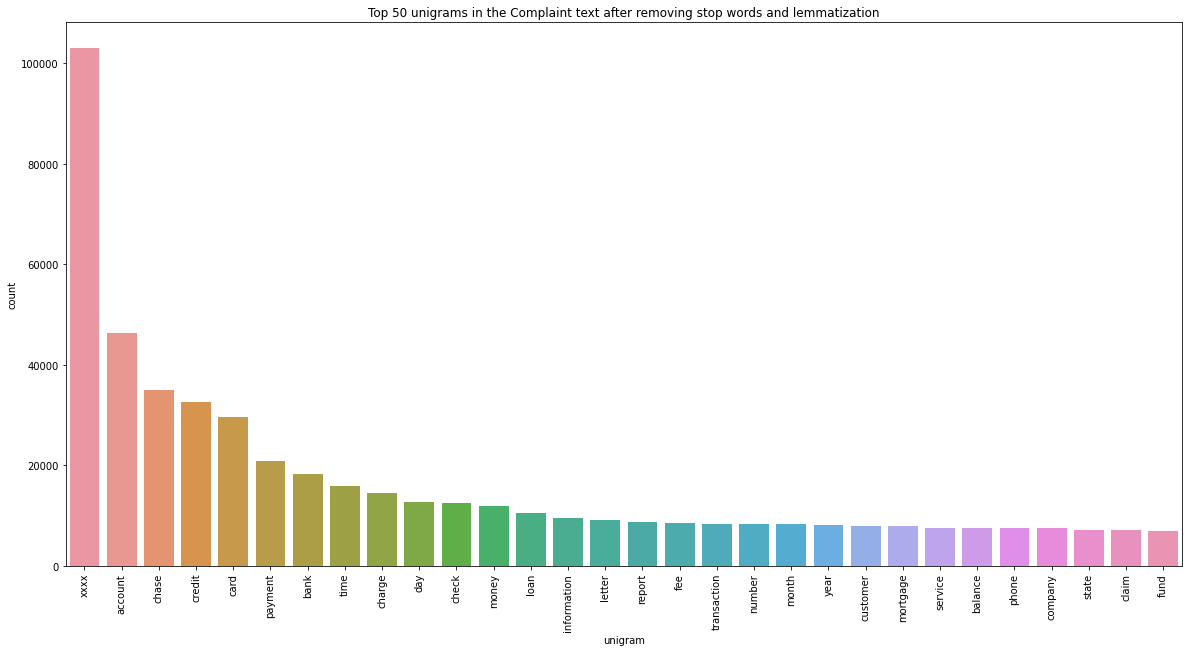

In [24]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
import seaborn as sns
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df_clean['complaint_clean'].values.astype('U'), 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

plt.figure(figsize=(20,10))
sns.barplot(x=df2['unigram'], y=df2['count'])
plt.xticks(rotation=90)
plt.title("Top 50 unigrams in the Complaint text after removing stop words and lemmatization")
plt.show()

In [25]:
#Print the top 10 words in the unigram frequency
df2.head(10)

,unigram,count
0,xxxx,102973
1,account,46331
2,chase,34962
3,credit,32612
4,card,29594
5,payment,20964
6,bank,18402
7,time,15897
8,charge,14612
9,day,12780


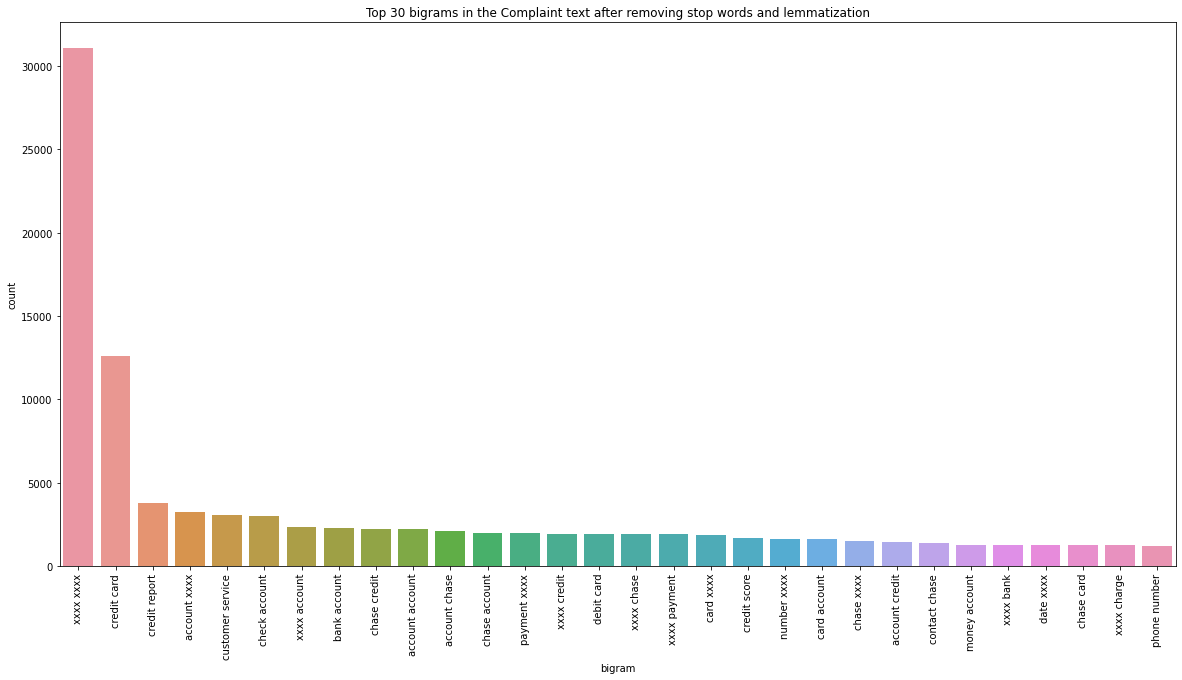

In [26]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df_clean['complaint_clean'].values.astype('U'), 30)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

plt.figure(figsize=(20,10))
sns.barplot(x=df3['bigram'], y=df3['count'])
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text after removing stop words and lemmatization")
plt.show()

In [27]:
#Print the top 10 words in the bigram frequency
df3.head(10)

,bigram,count
0,xxxx xxxx,31078
1,credit card,12580
2,credit report,3792
3,account xxxx,3240
4,customer service,3032
5,check account,3001
6,xxxx account,2360
7,bank account,2274
8,chase credit,2205
9,account account,2192


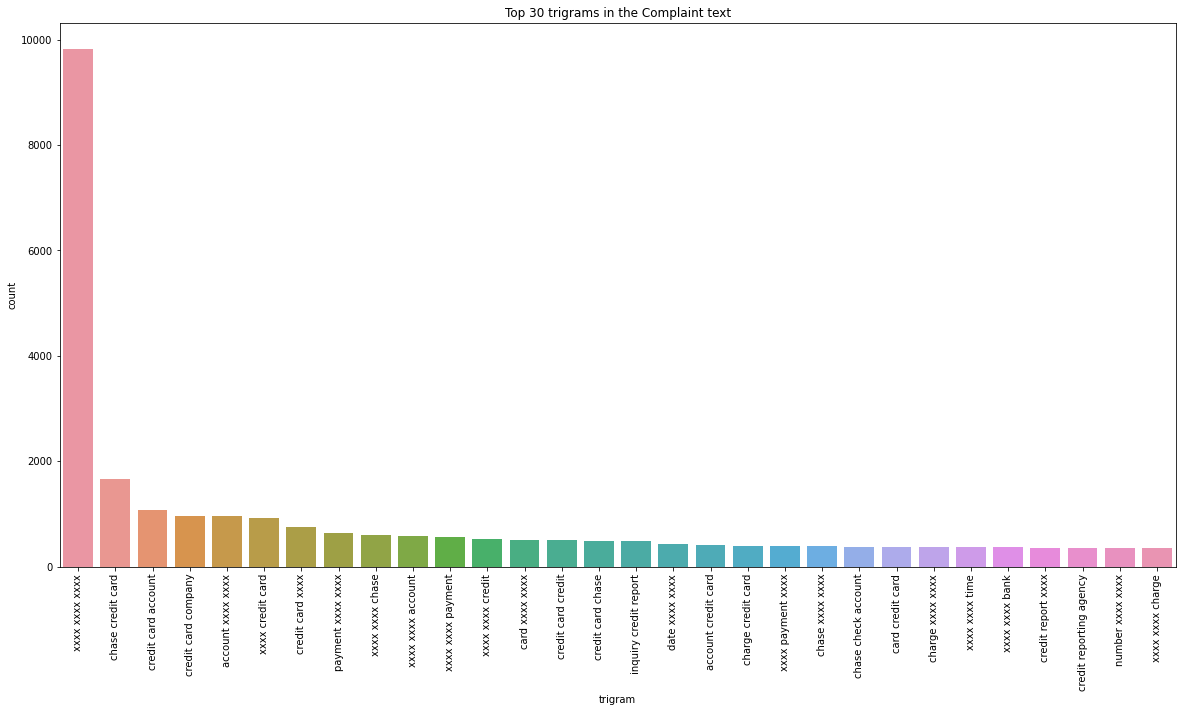

In [28]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df_clean['complaint_clean'].values.astype('U'), 30)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

plt.figure(figsize=(20,10))
sns.barplot(x=df4['trigram'], y=df4['count'])
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text")
plt.show()

In [29]:
#Print the top 10 words in the trigram frequency
df4.head(10)

,trigram,count
0,xxxx xxxx xxxx,9821
1,chase credit card,1664
2,credit card account,1066
3,credit card company,969
4,account xxxx xxxx,959
5,xxxx credit card,926
6,credit card xxxx,749
7,payment xxxx xxxx,639
8,xxxx xxxx chase,606
9,xxxx xxxx account,589


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [30]:
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx','')

In [31]:
for unigram, freq in get_top_n_words(df_clean.complaint_clean, 10):
    print(unigram)

account
chase
credit
card
payment
bank
time
charge
day
check


In [32]:
#All masked texts has been removed
df_clean

,complaint_clean,complaint_what_happened,complaint_POS_removed
0,morning name stop cardmember service write de...,Good morning my name is XXXX XXXX and I apprec...,morning name xxxx stop cardmember service writ...
1,card agent upgrade anniversary date agent inf...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,xxxx card agent upgrade anniversary date agent...
2,card report application identity consent servi...,Chase Card was reported on XX/XX/2019. However...,card report application identity consent servi...
3,ticket offer ticket reward card information o...,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx ticket offer ticket reward card informati...
4,son deposit chase account fund chase bank acco...,my grand son give me check for {$1600.00} i de...,son deposit chase account fund chase bank acco...
...,...,...,...
21067,chase card customer decade solicitation credit...,After being a Chase Card customer for well ove...,chase card customer decade solicitation credit...
21068,credit card provider claim purchase protection...,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",credit card provider claim purchase protection...
21069,risk consumer chase bank app chase year banki...,I am not familiar with XXXX pay and did not un...,xxxx risk consumer chase bank app chase year b...
21070,credit credit card chase freedom problem bala...,I have had flawless credit for 30 yrs. I've ha...,credit credit card chase freedom xxxx problem ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [33]:
#Write your code here to initialise the TfidfVectorizer 
vect = TfidfVectorizer(stop_words='english',max_df=0.95, min_df=2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [34]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
X = vect.fit_transform(df_clean.complaint_clean)
print(X)

  (0, 2679)	0.19054084955559655
  (0, 117)	0.2568841630943436
  (0, 40)	0.07928378057233156
  (0, 934)	0.07882201505252556
  (0, 1253)	0.17789837258475477
  (0, 2924)	0.126740013251943
  (0, 4928)	0.2140553870455569
  (0, 3649)	0.12728603956082643
  (0, 3394)	0.16186647207049112
  (0, 481)	0.10335920006856918
  (0, 5418)	0.15722410724007707
  (0, 6081)	0.25150401369315195
  (0, 1502)	0.5477756478902824
  (0, 6290)	0.2810752615590203
  (0, 5137)	0.13377775016735835
  (0, 818)	0.34050900604136036
  (0, 5460)	0.2905192476628644
  (0, 3659)	0.23089011058312797
  (1, 4631)	0.24410356375723374
  (1, 1226)	0.21925908731979032
  (1, 3902)	0.1485844042677191
  (1, 1475)	0.24092428645771102
  (1, 246)	0.63252703979423
  (1, 6010)	0.31521118746545135
  (1, 156)	0.5389885700216106
  :	:
  (21070, 4050)	0.37435164090499096
  (21070, 2242)	0.12138606162371382
  (21070, 4797)	0.1389914528576351
  (21070, 1397)	0.14514018144736904
  (21070, 815)	0.2368041428143458
  (21070, 934)	0.13139167931046894
  

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [35]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [36]:
#Function to find Top 15 words against each topic, where number of topics can be passed as a parameter
def getTopWordsForTopics(num_topics):
    nmf_model = NMF(num_topics, random_state =40)
    W = nmf_model.fit_transform(X)
    H = nmf_model.components_
    words = np.array(vect.get_feature_names_out())
    num_top_words = 15
    topic_words_df = pd.DataFrame(np.zeros((num_topics, num_top_words)), 
                                index=[f'Topic {i}' for i in range(num_topics)],
                                columns=[f'Word {i}' for i in range(num_top_words)]).astype(str)

    for i in range(num_topics):
        ix = H[i].argsort()[::-1][:num_top_words]
        topic_words_df.iloc[i] = words[ix]

    return topic_words_df

In [37]:
#Testing for 2 topics
getTopWordsForTopics(2).head()

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,account,check,bank,money,chase,fund,deposit,transaction,day,fee,branch,claim,number,time,payment
Topic 1,credit,card,payment,report,chase,charge,inquiry,company,balance,time,loan,month,letter,year,dispute


In [38]:
#Testing for 3 topics
getTopWordsForTopics(3).head()

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,account,check,bank,money,fund,chase,deposit,transaction,day,fee,branch,claim,number,charge,fraud
Topic 1,credit,card,report,charge,chase,inquiry,company,dispute,balance,account,score,information,purchase,letter,service
Topic 2,payment,loan,mortgage,month,chase,home,modification,time,year,rate,balance,property,date,statement,fee


In [39]:
#Testing for 4 topics
getTopWordsForTopics(4).head()

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,account,check,bank,money,fund,deposit,chase,branch,day,number,business,transfer,transaction,customer,claim
Topic 1,credit,card,report,inquiry,account,chase,score,company,application,information,limit,balance,debt,letter,year
Topic 2,payment,loan,mortgage,month,home,chase,modification,time,year,rate,balance,property,date,statement,day
Topic 3,charge,card,fee,dispute,transaction,chase,merchant,purchase,claim,fraud,service,time,email,statement,company


In [40]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(num_topics, random_state =40)#write your code here

In [41]:
#nmf_model.fit(dtm)
#len(tfidf.get_feature_names())

W = nmf_model.fit_transform(X)
H = nmf_model.components_

In [42]:
#Print the Top15 words for each of the topics
words = np.array(vect.get_feature_names_out())

num_top_words = 15
topic_words_df = pd.DataFrame(np.zeros((num_topics, num_top_words)), 
                              index=[f'Topic {i}' for i in range(num_topics)],
                              columns=[f'Word {i}' for i in range(num_top_words)]).astype(str)

for i in range(num_topics):
    ix = H[i].argsort()[::-1][:num_top_words]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,account,check,bank,money,fund,deposit,chase,branch,day,number,business,transfer,transaction,customer,claim
Topic 1,credit,card,report,inquiry,account,chase,score,company,information,limit,debt,application,letter,year,balance
Topic 2,payment,balance,month,fee,statement,auto,day,time,date,chase,pay,credit,account,year,mortgage
Topic 3,charge,card,dispute,fee,transaction,chase,merchant,purchase,claim,fraud,service,time,email,statement,company
Topic 4,loan,mortgage,home,modification,chase,property,year,letter,document,rate,time,foreclosure,house,sale,request


In [43]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
colNames = [f'Topic {i}' for i in range(num_topics)]
rowNames = [f'Doc {i}' for i in range(len(df_clean.complaint_clean))]

df_documentTopics = pd.DataFrame(np.round(W,2), columns=colNames, index=rowNames)
best_topic = np.argmax(df_documentTopics.values,axis=1)
df_documentTopics['best_topic'] = best_topic
df_documentTopics.head(3)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,best_topic
Doc 0,0.02,0.01,0.01,0.01,0.02,0
Doc 1,0.01,0.01,0.00,0.01,0.00,0
Doc 2,0.00,0.06,0.00,0.00,0.00,1


In [44]:
print(len(df_documentTopics))
print(len(df_clean))

21072
21072


In [45]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = best_topic #write your code to assign topics to each rows.

In [46]:
df_clean.head()

,complaint_clean,complaint_what_happened,complaint_POS_removed,Topic
0,morning name stop cardmember service write de...,Good morning my name is XXXX XXXX and I apprec...,morning name xxxx stop cardmember service writ...,0
1,card agent upgrade anniversary date agent inf...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,xxxx card agent upgrade anniversary date agent...,0
2,card report application identity consent servi...,Chase Card was reported on XX/XX/2019. However...,card report application identity consent servi...,1
3,ticket offer ticket reward card information o...,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx ticket offer ticket reward card informati...,1
4,son deposit chase account fund chase bank acco...,my grand son give me check for {$1600.00} i de...,son deposit chase account fund chase bank acco...,0


In [47]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5 = df_clean_5.sort_values('Topic')
names = {0:'Account',
          1:'Credit card',
          2:'Miscellaneous services',
          3:'Fraud',
          4:'Mortgage'}
df_clean_5['Topic_names'] =  df_clean_5.Topic.map(names)
pd.options.display.max_colwidth = 200
df_clean_5

,complaint_clean,complaint_what_happened,complaint_POS_removed,Topic,Topic_names
0,morning name stop cardmember service write debt verification statement bank debt mail month debt right information consumer chase account advance help,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...,morning name xxxx stop cardmember service write debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help,0,Account
1,card agent upgrade anniversary date agent information order account anniversary date consent recording agent,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to u...,xxxx card agent upgrade anniversary date agent information order account xxxx anniversary date xxxx xxxx consent xxxx recording agent,0,Account
4,son deposit chase account fund chase bank account money son money chase bank money son time check owner country time date check number claim number chase,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son ...,son deposit chase account fund chase bank account money son money chase bank money son time check owner country time date check number xxxx claim number xxxx chase,0,Account
6,notice account debit card branch customer service representative account branch fund deposit place employment bank associate customer service representative assure fund business day attempt branch...,With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative th...,notice account debit card branch customer service representative account branch fund deposit place employment bank associate customer service representative assure fund business day attempt branch...,0,Account
10,mishandle account,mishandling of this account by Chase auto and XXXX.,mishandle account xxxx,0,Account
2,card report application identity consent service credit identity applicant,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying th...",card report application identity consent service credit identity applicant,1,Credit card
3,ticket offer ticket reward card information offer minute screen decision bank notification screen representative application deny information offer credit offer account statement use ticket acc...,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the off...",xxxx ticket offer ticket reward card information offer minute screen decision xxxx bank notification screen representative application deny information xxxx offer credit offer account statement us...,1,Credit card
5,inquiry,Can you please remove inquiry,inquiry,1,Credit card
9,chase credit card datum credit report company issue,I have a Chase credit card which is incorrectly reporting data on my credit report. The company is not helping resolve the issue.,chase credit card datum credit report company issue,1,Credit card
11,time attempt inquiry remove creditor inquiry report attempt bank bureau inquiry person care issue attempt talkin bank inquiry remove credit report action kind credit account iquiry matter,I have reached out to XXXX several times in attempt to have this fraudulent inquiry removed I was told that I need to call and contact the original creditor that placed this inquiry on my report. ...,xxxx tim

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [48]:
df_clean.head(1)

,complaint_clean,complaint_what_happened,complaint_POS_removed,Topic
0,morning name stop cardmember service write debt verification statement bank debt mail month debt right information consumer chase account advance help,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...,morning name xxxx stop cardmember service write debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help,0


In [49]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:'Bank Account services',
               1:'Credit card or prepaid card',
               2:'Others',
               3:'Theft/Dispute Reporting',
               4:'Mortgage/Loan'}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [50]:
df_clean

,complaint_clean,complaint_what_happened,complaint_POS_removed,Topic
0,morning name stop cardmember service write debt verification statement bank debt mail month debt right information consumer chase account advance help,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...,morning name xxxx stop cardmember service write debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help,Bank Account services
1,card agent upgrade anniversary date agent information order account anniversary date consent recording agent,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to u...,xxxx card agent upgrade anniversary date agent information order account xxxx anniversary date xxxx xxxx consent xxxx recording agent,Bank Account services
2,card report application identity consent service credit identity applicant,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying th...",card report application identity consent service credit identity applicant,Credit card or prepaid card
3,ticket offer ticket reward card information offer minute screen decision bank notification screen representative application deny information offer credit offer account statement use ticket acc...,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the off...",xxxx ticket offer ticket reward card information offer minute screen decision xxxx bank notification screen representative application deny information xxxx offer credit offer account statement us...,Credit card or prepaid card
4,son deposit chase account fund chase bank account money son money chase bank money son time check owner country time date check number claim number chase,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son ...,son deposit chase account fund chase bank account money son money chase bank money son time check owner country time date check number xxxx claim number xxxx chase,Bank Account services
...,...,...,...,...
21067,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fee year month payment agree card approve card harm credit charge fee account point airline hotel enr...,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for acquiring new credit cards with Chase - all with bonus airline miles and hotel points. Was approved...",chase card customer decade solicitation credit card chase bonus airline mile hotel point card fee year month payment agree card approve card harm credit charge fee account point airline hotel xxxx...,Theft/Dispute Reporting
21068,credit card provider claim purchase protection benefit school textbook year daughter school book damage water bottle backpack chase representative assure textbook claim website claim paperwork co...,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to make a claim under their purchase protection benefit. On XX/XX/XXXX, I purchased three high school ...",credit card provider claim purchase protection benefit school textbook year daughter school book damage water bottle backpack chase representative assure textbook claim xxxx website claim paperwor...,Theft/Dispute Reporting
21069,risk consumer chase bank app chase year banking merchant merchant inquiry communication w

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [51]:
#Create the dictionary again of Topic names and Topics

Topic_names = {'Bank Account services':0,
               'Credit card or prepaid card':1,
               'Others':2,
               'Theft/Dispute Reporting':3,
               'Mortgage/Loan':4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [52]:
df_clean

,complaint_clean,complaint_what_happened,complaint_POS_removed,Topic
0,morning name stop cardmember service write debt verification statement bank debt mail month debt right information consumer chase account advance help,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...,morning name xxxx stop cardmember service write debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help,0
1,card agent upgrade anniversary date agent information order account anniversary date consent recording agent,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to u...,xxxx card agent upgrade anniversary date agent information order account xxxx anniversary date xxxx xxxx consent xxxx recording agent,0
2,card report application identity consent service credit identity applicant,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying th...",card report application identity consent service credit identity applicant,1
3,ticket offer ticket reward card information offer minute screen decision bank notification screen representative application deny information offer credit offer account statement use ticket acc...,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the off...",xxxx ticket offer ticket reward card information offer minute screen decision xxxx bank notification screen representative application deny information xxxx offer credit offer account statement us...,1
4,son deposit chase account fund chase bank account money son money chase bank money son time check owner country time date check number claim number chase,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son ...,son deposit chase account fund chase bank account money son money chase bank money son time check owner country time date check number xxxx claim number xxxx chase,0
...,...,...,...,...
21067,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fee year month payment agree card approve card harm credit charge fee account point airline hotel enr...,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for acquiring new credit cards with Chase - all with bonus airline miles and hotel points. Was approved...",chase card customer decade solicitation credit card chase bonus airline mile hotel point card fee year month payment agree card approve card harm credit charge fee account point airline hotel xxxx...,3
21068,credit card provider claim purchase protection benefit school textbook year daughter school book damage water bottle backpack chase representative assure textbook claim website claim paperwork co...,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to make a claim under their purchase protection benefit. On XX/XX/XXXX, I purchased three high school ...",credit card provider claim purchase protection benefit school textbook year daughter school book damage water bottle backpack chase representative assure textbook claim xxxx website claim paperwor...,3
21069,risk consumer chase bank app chase year banking merchant merchant inquiry communication website merchant face brand link medium consent perform research phone number information pi merchant accou...,I am not familiar with XXXX pay and did not un

In [53]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaint_what_happened','Topic']]

In [54]:
training_data.head()

,complaint_what_happened,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to u...,0
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying th...",1
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the off...",1
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son ...,0


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [55]:
from sklearn.feature_extraction.text import TfidfTransformer

In [56]:
#Write your code to get the Vector count
countVec = CountVectorizer()
X = countVec.fit_transform(training_data.complaint_what_happened)

#Write your code here to transform the word vector to tf-idf
tfidfTrans = TfidfTransformer()
X_tfidf = tfidfTrans.fit_transform(X)

y = training_data.Topic

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.20, random_state=42)

In [58]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16857, 29725)
(4215, 29725)
(16857,)
(4215,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

## 1. Decision Tree

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.linear_model import LogisticRegression

In [60]:
dt = DecisionTreeClassifier(random_state=42)

params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, 
                           n_jobs=-1, 
                           verbose=1, 
                           scoring = "accuracy")

grid_search.fit(X_train, y_train)

grid_search.best_estimator_

Fitting 4 folds for each of 50 candidates, totalling 200 fits


DecisionTreeClassifier(max_depth=20, min_samples_leaf=20, random_state=42)

In [61]:
dt_best = grid_search.best_estimator_
y_train_pred = dt_best.predict(X_train)
y_test_pred = dt_best.predict(X_test)

In [62]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      4517
           1       0.87      0.87      0.87      4084
           2       0.83      0.84      0.83      1865
           3       0.84      0.77      0.81      3657
           4       0.79      0.87      0.83      2734

    accuracy                           0.84     16857
   macro avg       0.84      0.84      0.84     16857
weighted avg       0.84      0.84      0.84     16857



In [63]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1139
           1       0.80      0.80      0.80      1077
           2       0.76      0.78      0.77       446
           3       0.76      0.67      0.71       923
           4       0.75      0.86      0.80       630

    accuracy                           0.78      4215
   macro avg       0.78      0.78      0.78      4215
weighted avg       0.78      0.78      0.78      4215



## 2. Random Forest Classifier

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
rf = RandomForestClassifier(random_state=42, 
                            n_jobs=-1)

params = {
    'max_depth': [3,5,10,15,20],
    'min_samples_leaf': [10,20,50],
    'n_estimators': [10, 25, 50],
    'criterion': ["entropy", "gini"]
}

grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, 
                           verbose=1, 
                           scoring= 'precision_weighted')

grid_search.fit(X_train,y_train)

rf_best = grid_search.best_estimator_
print(rf_best)

Fitting 4 folds for each of 90 candidates, totalling 360 fits
RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=10,
                       n_estimators=50, n_jobs=-1, random_state=42)


In [66]:
y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)

print('********SCORES FOR TRAIN DATA PREDICTION*********')
print(classification_report(y_train, y_train_pred))
print('********SCORES FOR TEST DATA PREDICTION*********')
print(classification_report(y_test, y_test_pred))

********SCORES FOR TRAIN DATA PREDICTION*********
              precision    recall  f1-score   support

           0       0.76      0.92      0.84      4517
           1       0.71      0.90      0.80      4084
           2       0.98      0.24      0.39      1865
           3       0.85      0.78      0.82      3657
           4       0.88      0.79      0.83      2734

    accuracy                           0.79     16857
   macro avg       0.84      0.73      0.73     16857
weighted avg       0.81      0.79      0.77     16857

********SCORES FOR TEST DATA PREDICTION*********
              precision    recall  f1-score   support

           0       0.71      0.89      0.79      1139
           1       0.70      0.84      0.76      1077
           2       0.90      0.13      0.23       446
           3       0.78      0.69      0.73       923
           4       0.84      0.79      0.81       630

    accuracy                           0.74      4215
   macro avg       0.78      0.6

## 3. Logistic Regression

In [75]:
logReg = LogisticRegression(max_iter=200).fit(X_train, y_train)
y_train_pred = logReg.predict(X_train)
y_test_pred = logReg.predict(X_test)

print('********SCORES FOR TRAIN DATA PREDICTION*********')
print(classification_report(y_train, y_train_pred))
print('********SCORES FOR TEST DATA PREDICTION*********')
print(classification_report(y_test, y_test_pred))

********SCORES FOR TRAIN DATA PREDICTION*********
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4517
           1       0.96      0.97      0.97      4084
           2       0.98      0.93      0.96      1865
           3       0.95      0.95      0.95      3657
           4       0.98      0.97      0.98      2734

    accuracy                           0.96     16857
   macro avg       0.97      0.96      0.96     16857
weighted avg       0.96      0.96      0.96     16857

********SCORES FOR TEST DATA PREDICTION*********
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1139
           1       0.92      0.92      0.92      1077
           2       0.92      0.86      0.89       446
           3       0.90      0.86      0.88       923
           4       0.92      0.94      0.93       630

    accuracy                           0.91      4215
   macro avg       0.91      0.9

## 4. Naive Bayes

In [76]:
from sklearn.naive_bayes import MultinomialNB

In [77]:
nb = MultinomialNB().fit(X_train, y_train)

y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

print('********SCORES FOR TRAIN DATA PREDICTION*********')
print(classification_report(y_train, y_train_pred))
print('********SCORES FOR TEST DATA PREDICTION*********')
print(classification_report(y_test, y_test_pred))

********SCORES FOR TRAIN DATA PREDICTION*********
              precision    recall  f1-score   support

           0       0.61      0.94      0.74      4517
           1       0.72      0.81      0.76      4084
           2       0.97      0.03      0.06      1865
           3       0.84      0.72      0.77      3657
           4       0.89      0.70      0.78      2734

    accuracy                           0.72     16857
   macro avg       0.81      0.64      0.62     16857
weighted avg       0.77      0.72      0.69     16857

********SCORES FOR TEST DATA PREDICTION*********
              precision    recall  f1-score   support

           0       0.58      0.93      0.71      1139
           1       0.71      0.76      0.73      1077
           2       0.88      0.02      0.03       446
           3       0.81      0.64      0.71       923
           4       0.89      0.68      0.77       630

    accuracy                           0.69      4215
   macro avg       0.77      0.6

# Conclusion

## Logistic Regression Seems to be the best model which we have built with a good metrics

### - Train Accuracy: 96%
### - Test Accuracy: 91%

##### Model Metrics:

In [80]:
#Model Metrics
y_train_pred = logReg.predict(X_train)
y_test_pred = logReg.predict(X_test)

print('********SCORES FOR TRAIN DATA PREDICTION*********')
print(classification_report(y_train, y_train_pred))
print('********SCORES FOR TEST DATA PREDICTION*********')
print(classification_report(y_test, y_test_pred))

********SCORES FOR TRAIN DATA PREDICTION*********
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4517
           1       0.96      0.97      0.97      4084
           2       0.98      0.93      0.96      1865
           3       0.95      0.95      0.95      3657
           4       0.98      0.97      0.98      2734

    accuracy                           0.96     16857
   macro avg       0.97      0.96      0.96     16857
weighted avg       0.96      0.96      0.96     16857

********SCORES FOR TEST DATA PREDICTION*********
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1139
           1       0.92      0.92      0.92      1077
           2       0.92      0.86      0.89       446
           3       0.90      0.86      0.88       923
           4       0.92      0.94      0.93       630

    accuracy                           0.91      4215
   macro avg       0.91      0.9